# Titanic
For the previous examples we have used fabricated data, however, in this example we will use the titanic data set. In this example we will compare the results against a decision tree which has been trained to ~90% accuracy. The Random Forest code was taken from https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy by user **VK_ds** with the goal of making a direct comparison between techniques

## Imports

In [1]:
import warnings
import re
import math
import Levenshtein
from typing import List, Dict
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import norm
from statistics import mean, stdev
from matplotlib.colors import LinearSegmentedColormap


scaler = MinMaxScaler()
warnings.filterwarnings("ignore")
%matplotlib inline

## Cleaning the Data
A lot of effort is taken to clean and prepare the data. A large part of this process reduces the noise that would have a negative effect on the performance of both algorithms

In [2]:
train_df=pd.read_csv("../data/train.csv")
test_df=pd.read_csv("../data/test.csv")

In [3]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

In [4]:
drop_column = ['Cabin']
train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column,axis=1,inplace=True)

In [5]:
test_df['Age'].fillna(test_df['Age'].median(), inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

In [6]:
all_data=[train_df,test_df]
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [7]:
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    if title_search:
        return title_search.group(1)
    return ""

In [8]:
for dataset in all_data:
    dataset["Title"] = dataset["Name"].apply(get_title)
for dataset in all_data:
    dataset["Title"] = dataset["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

In [9]:
for dataset in all_data:
    dataset["Age_bin"] = pd.cut(
        dataset["Age"],
        bins=[0, 12, 20, 40, 120],
        labels=["Children", "Teenage", "Adult", "Elder"],
    )

In [10]:
for dataset in all_data:
    dataset["Fare_bin"] = pd.cut(
        dataset["Fare"],
        bins=[0, 7.91, 14.45, 31, 120],
        labels=["Low_fare", "median_fare", "Average_fare", "high_fare"],
    )

In [11]:
traindf=train_df
testdf=test_df

In [12]:
all_dat=[traindf,testdf]
for dataset in all_dat:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [13]:
drop_column = ['PassengerId']
traindf.drop(drop_column, axis=1, inplace = True)

In [14]:
testdf.head(2)

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Age_bin,Fare_bin
0,892,3,male,0,0,Q,1,Mr,Adult,Low_fare
1,893,3,female,1,0,S,2,Mrs,Elder,Low_fare


In [15]:
traindf = pd.get_dummies(
    traindf,
    columns=["Sex", "Title", "Age_bin", "Embarked", "Fare_bin"],
    prefix=["Sex", "Title", "Age_type", "Em_type", "Fare_type"],
)

In [16]:
testdf = pd.get_dummies(
    testdf,
    columns=["Sex", "Title", "Age_bin", "Embarked", "Fare_bin"],
    prefix=["Sex", "Title", "Age_type", "Em_type", "Fare_type"],
)

In [17]:
testdf.head(3)

,PassengerId,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,892,3,0,0,1,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
1,893,3,1,0,2,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,894,2,0,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0


In [18]:
all_features = traindf.drop("Survived", axis=1)
Targeted_feature = traindf["Survived"]
X_train, X_test, y_train, y_test = train_test_split(
    all_features, Targeted_feature, test_size=0.3, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 22), (268, 22), (623,), (268,))

In [19]:
train_X = traindf.drop("Survived", axis=1)
train_Y=traindf["Survived"]
test_X  = testdf.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape

((891, 22), (891,), (418, 22))

## Random Forest
This section runs the Random Forest algorithm against the data. One of the nice features of this particular type of algorithm is that the feature importance is generated as it runs. We will make a direct comparison of this output later in the notebook

In [20]:
random_forest = RandomForestClassifier(
    bootstrap=True,
    class_weight=None,
    criterion="gini",
    max_depth=None,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=400,
    n_jobs=1,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False,
)
random_forest.fit(train_X, train_Y)
Y_pred_rf = random_forest.predict(test_X)
random_forest.score(train_X, train_Y)
acc_random_forest = round(random_forest.score(train_X, train_Y) * 100, 2)

In [21]:
light = "#90CCF4"
darker = "#5DA2D5"
important = "#F3D250"
noise = "#F78888"
other = "#ECECEC"

colors = [noise, darker, light, important]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
colors = cmap(np.linspace(0, 1, len(train_X.columns)))

RANDOM FOREST ACCURACY: 89.11%


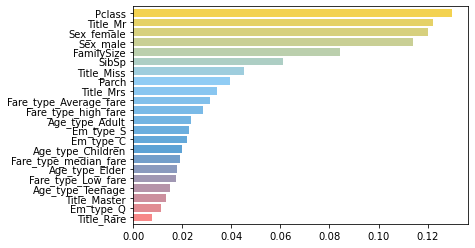

In [22]:
pd.Series(random_forest.feature_importances_, train_X.columns).sort_values(
    ascending=True
).plot.barh(width=0.8, color=colors)
print(f"RANDOM FOREST ACCURACY: {acc_random_forest}%")

## Defining and Running the Neural Network Model
Now we turn our attention to the neural network. The setup is the same as has been seen in previous notebooks and we are using exactly the same data set as was used for the Random Forest

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(6, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-12-05 23:42:30.074637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-05 23:42:30.074770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
def create_history(columns: int, nodes: int) -> Dict:
    return {i:{j: [] for j in range(nodes)} for i in range(columns)}

In [25]:
COLUMNS = list(train_X.columns)

In [26]:
history = create_history(len(COLUMNS), 6)

In [27]:
for epoch in range(1, 501):
    print(f"RUNNING EPOCH {epoch}")
    hist = model.fit(x=train_X, 
      y=train_Y, 
      epochs=1,
      batch_size=100,
      )
    all_weights = model.layers[0].get_weights()[0].tolist()
    for column in range(len(all_weights)):
        for node in range(len(all_weights[column])):
            history[column][node].append(all_weights[column][node])

RUNNING EPOCH 1


2022-12-05 23:42:30.232418: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/9 [==>...........................] - ETA: 3s - loss: 0.6905 - accuracy: 0.6100

2022-12-05 23:42:30.466320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 12ms/step - loss: 0.6916 - accuracy: 0.6521
RUNNING EPOCH 2
9/9 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.6521
RUNNING EPOCH 3
9/9 [==============================] - 0s 6ms/step - loss: 0.6751 - accuracy: 0.6487
RUNNING EPOCH 4
9/9 [==============================] - 0s 6ms/step - loss: 0.6644 - accuracy: 0.6622
RUNNING EPOCH 5
9/9 [==============================] - 0s 6ms/step - loss: 0.6528 - accuracy: 0.6700
RUNNING EPOCH 6
9/9 [==============================] - 0s 6ms/step - loss: 0.6406 - accuracy: 0.6723
RUNNING EPOCH 7
9/9 [==============================] - 0s 7ms/step - loss: 0.6294 - accuracy: 0.6857
RUNNING EPOCH 8
9/9 [==============================] - 0s 6ms/step - loss: 0.6172 - accuracy: 0.6981
RUNNING EPOCH 9
9/9 [==============================] - 0s 6ms/step - loss: 0.6047 - accuracy: 0.7273
RUNNING EPOCH 10
9/9 [==============================] - 0s 6ms/step - loss: 0.5918 - accuracy: 0.7318
RUNN

## Evaluating the Model

## Splitting weights into groups
This will follow the same steps as we have seen before, however, we add an additional step. Since we already have a sensible order of feature importance, we will use this for our coloration until we have produced our feature importance outputs. This will allow us to make sense of much busier plots

In [28]:
def get_groups(index: int, nodes: int) -> List:
    group = []
    for i in range(nodes):
        group.append(history[index][i])
    return group

In [29]:
Pclass = get_groups(0, 6)
SibSp = get_groups(1, 6)
Parch = get_groups(2, 6)
FamilySize = get_groups(3, 6)
Sex_female = get_groups(4, 6)
Sex_male = get_groups(5, 6)
Title_Master = get_groups(6, 6)
Title_Miss = get_groups(7, 6)
Title_Mr = get_groups(8, 6)
Title_Mrs = get_groups(9, 6)
Title_Rare = get_groups(10, 6)
Age_type_Children = get_groups(11, 6)
Age_type_Teenage = get_groups(12, 6)
Age_type_Adult = get_groups(13, 6)
Age_type_Elder = get_groups(14, 6)
Em_type_C = get_groups(15, 6)
Em_type_Q = get_groups(16, 6)
Em_type_S = get_groups(17, 6)
Fare_type_Low_fare = get_groups(18, 6)
Fare_type_median_fare = get_groups(19, 6)
Fare_type_Average_fare = get_groups(20, 6)
Fare_type_high_fare = get_groups(21, 6)

In [30]:
group_dict = {
    "Pclass": Pclass,
    "SibSp": SibSp,
    "Parch": Parch,
    "FamilySize": FamilySize,
    "Sex_female": Sex_female,
    "Sex_male": Sex_male,
    "Title_Master": Title_Master,
    "Title_Miss": Title_Miss,
    "Title_Mr": Title_Mr,
    "Title_Mrs": Title_Mrs,
    "Title_Rare": Title_Rare,
    "Age_type_Children": Age_type_Children,
    "Age_type_Teenage": Age_type_Teenage,
    "Age_type_Adult": Age_type_Adult,
    "Age_type_Elder": Age_type_Elder,
    "Em_type_C": Em_type_C,
    "Em_type_Q": Em_type_Q,
    "Em_type_S": Em_type_S,
    "Fare_type_Low_fare": Fare_type_Low_fare,
    "Fare_type_median_fare": Fare_type_median_fare,
    "Fare_type_Average_fare": Fare_type_Average_fare,
    "Fare_type_high_fare": Fare_type_high_fare,
}

In [31]:
sorted_columns = pd.Series(random_forest.feature_importances_, train_X.columns).sort_values(
    ascending=True
).index.tolist()

## Box Plots

In [32]:
def generate_box_plot(ax, data: List, color: str, label: str, position_offset: int = 0, showfliers: bool = False):
    ax.set_xlabel("Input Column and Node Number")
    ax.set_ylabel("Weight Values")
    color = {"color": color}
    ax.boxplot(
        data,
        positions=[i + position_offset for i in range(1,7)],
        boxprops=color,
        medianprops=color,
        whiskerprops=color,
        capprops=color,
        flierprops={"markeredgecolor": other},
        showfliers=showfliers,
        labels=[f"{label}{i}" for i in range(1,7)]
    )

In [33]:
all_fields_ordered = [group_dict[sorted_columns[i]] for i in range(len(sorted_columns))]

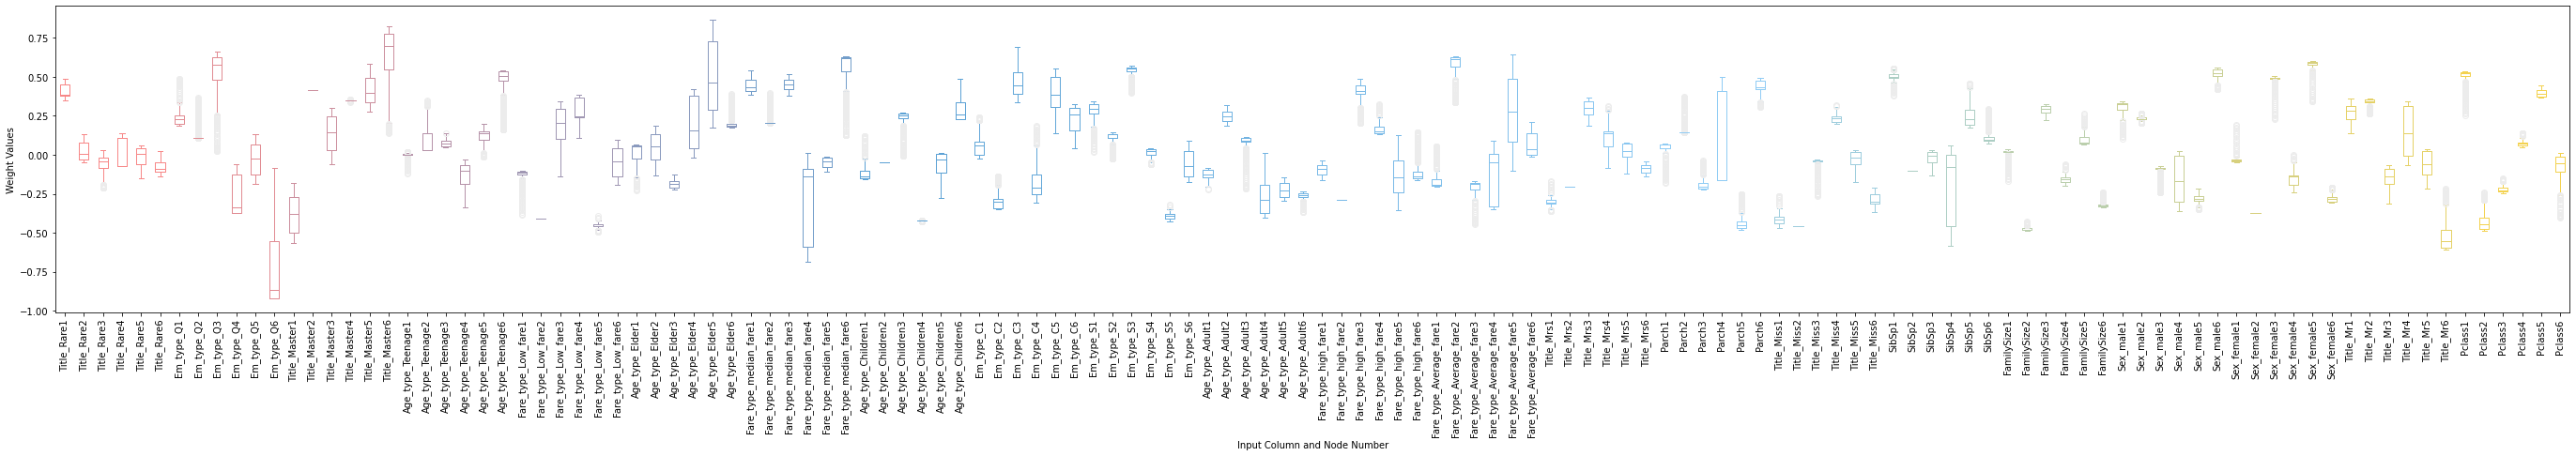

In [34]:
fig, ax = plt.subplots(figsize=(48,6))

for i, field in enumerate(all_fields_ordered):
    generate_box_plot(ax, field, colors[i], sorted_columns[i], i * 6, showfliers=True)
for label in ax.get_xticklabels():
    label.set_rotation(90)

## Probability Densities

In [35]:
def get_group_by_node(index: int) -> List:
    group = []
    for i in list(history.keys()):
        group.append(history[i][index])
    return group

In [36]:
group_one = get_group_by_node(0)
group_two = get_group_by_node(1)
group_three = get_group_by_node(2)
group_four = get_group_by_node(3)
group_five = get_group_by_node(4)
group_six = get_group_by_node(5)

In [37]:
def get_color_by_index(index: int):
    original_idnex = COLUMNS.index(sorted_columns[index])
    return colors[original_idnex]

In [38]:
def plot_stds(group):
    _, ax = plt.subplots(figsize=(16,6))
    domain = np.linspace(-2,2,1000)
    means = [mean(group[i]) for i in range(len(group))]
    stds = [stdev(group[i]) for i in range(len(group))]
    colors = [get_color_by_index(i) for i in range(len(group))]
    for mu, std, color in zip(means, stds, colors):
        probs = norm.pdf(domain, mu, std)
        ax.plot(domain, probs, color=color)
        ax.set_xlabel("Weight")
        ax.set_ylabel("Probability Density")

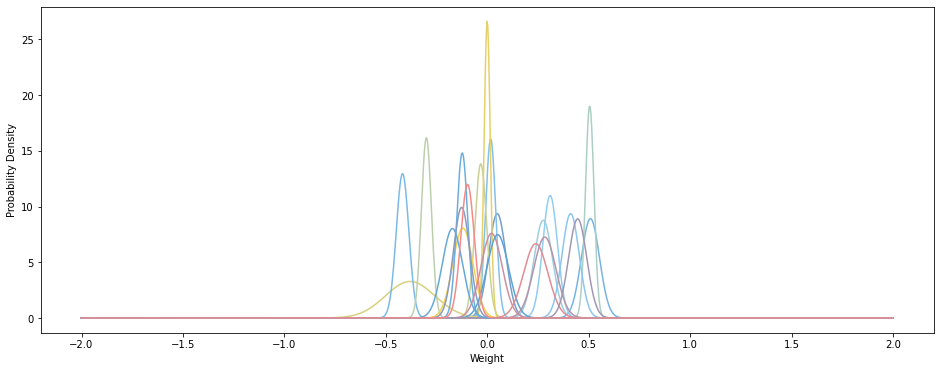

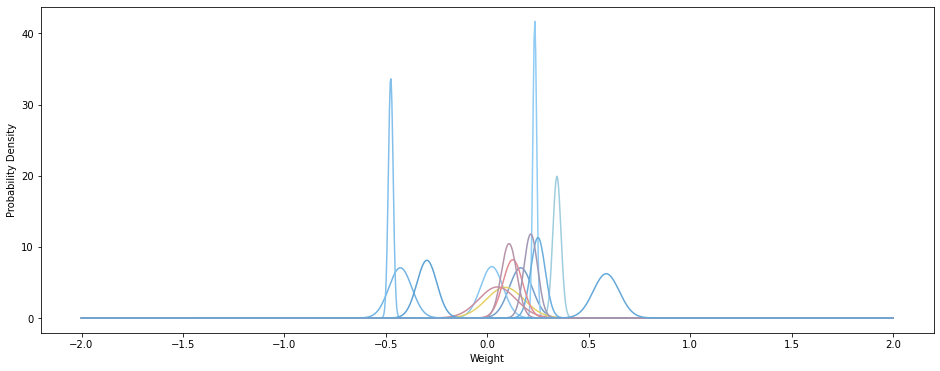

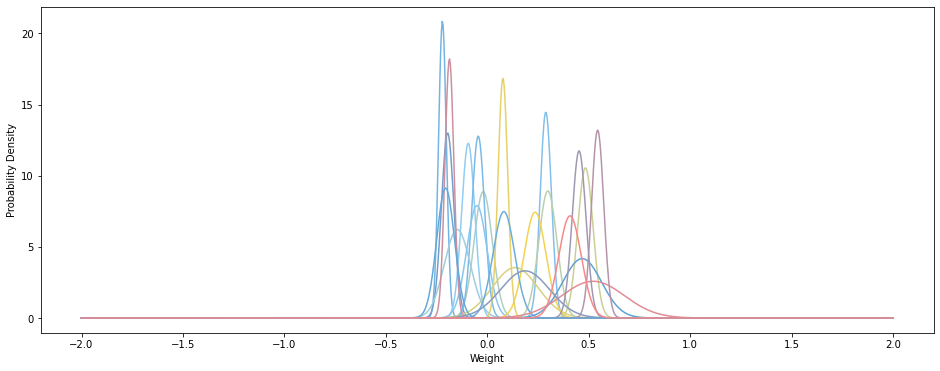

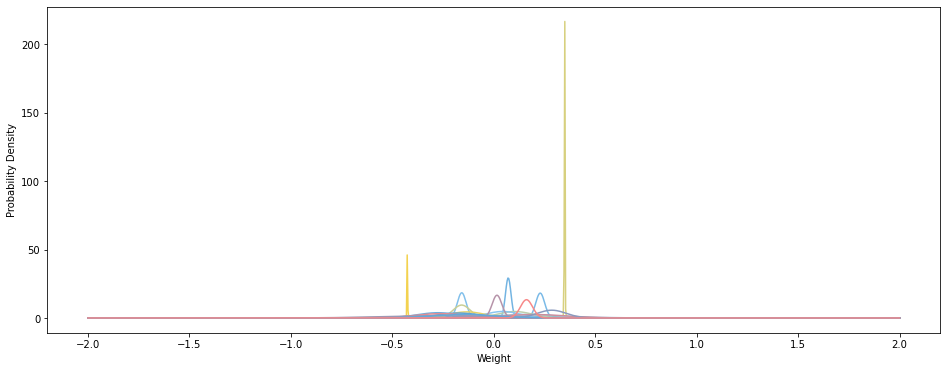

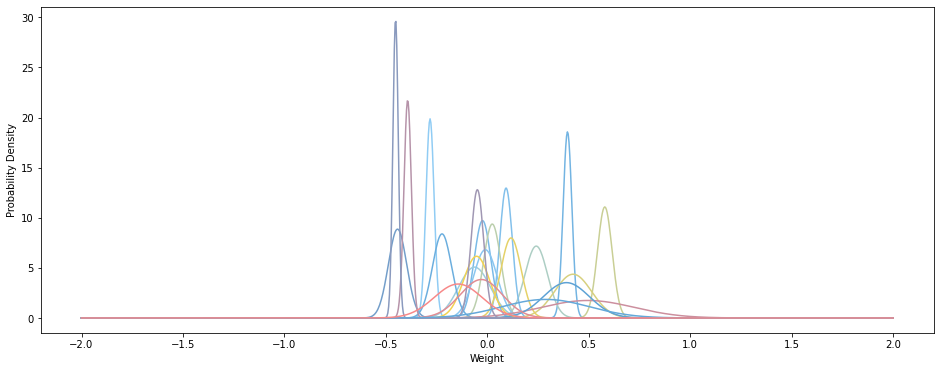

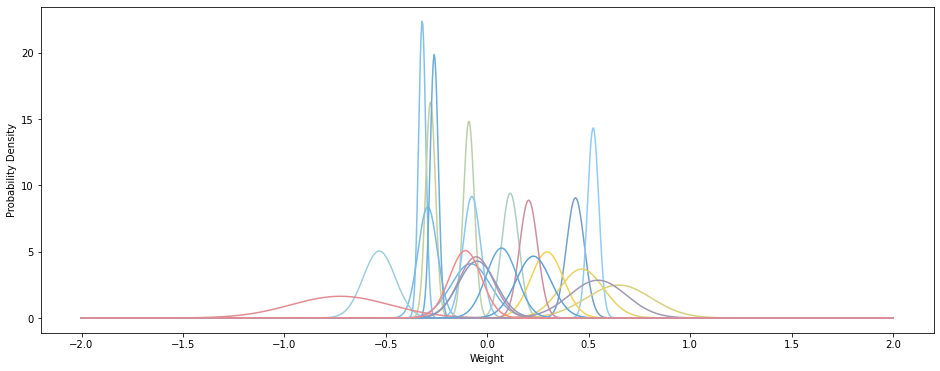

In [39]:
plot_stds(group_one)
plot_stds(group_two)
plot_stds(group_three)
plot_stds(group_four)
plot_stds(group_five)
plot_stds(group_six)

## Evaluating the Probability Densities

In [40]:
def get_probs(group):
    domain = np.linspace(-2,2,1000)
    means = [mean(group[i]) for i in range(len(group))]
    stds = [stdev(group[i]) for i in range(len(group))]
    results = []
    for mu, std in zip(means, stds):
        if std:
            try:
                values = []
                probs = norm.pdf(domain, mu, std)
                for prob in probs:
                    if math.floor(prob) != 0:
                        values.append(prob)
                results.append(values)
            except ValueError:
                pass
    
    return results

In [41]:
groups = [group_one, group_two, group_three, group_four, group_five, group_six]
all_probs = [get_probs(group) for group in groups]

In [42]:
def barrage(all_probs, nodes: int):
    res = {
        i: {"len": 0, "max": 0, "sum": 0, "mean": 0, "stdev": 0} for i in range(nodes)
    }
    for probs in all_probs:
        for i, prob in enumerate(probs):
            try:
                res[i]["len"] += len(prob)
            except ValueError:
                pass
            try:
                res[i]["max"] += max(prob)
            except ValueError:
                pass
            try:
                res[i]["sum"] += sum(prob)
            except ValueError:
                pass
            try:
                res[i]["mean"] += mean(prob)
            except ValueError:
                pass
            try:
                res[i]["stdev"] += stdev(prob)
            except ValueError:
                pass
    return res

In [43]:
res = barrage(all_probs, len(COLUMNS))
for i in range(len(COLUMNS)):
    res[COLUMNS[i]] = res.pop(i)

In [44]:
df = pd.DataFrame(res)
df

,Pclass,SibSp,Parch,FamilySize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_C,Em_type_Q,Em_type_S,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
len,251.000000,350.000000,307.000000,157.000000,212.000000,292.000000,453.000000,228.000000,436.000000,277.000000,...,301.000000,304.000000,356.000000,388.000000,465.000000,215.000000,298.000000,343.000000,393.000000,288.000000
max,88.637141,53.243220,75.338054,125.933607,81.104255,67.479099,234.568718,73.292432,32.074023,62.092925,...,71.352496,60.585903,38.918816,23.425735,17.881116,63.300203,52.802257,37.877734,26.729126,40.995808
sum,1444.043946,1382.184631,1365.297064,1474.149906,1462.346403,1427.889627,1360.595813,1457.782766,1377.421685,1441.622936,...,1427.890212,1429.076247,1109.275335,1139.911133,1055.022178,1202.964087,1170.433639,1108.140564,1100.328824,1176.840119
mean,45.756566,30.011222,39.560400,62.742112,43.217446,36.560861,98.131184,39.993626,20.317403,34.640086,...,38.503118,33.641338,22.126801,15.331644,12.313081,34.448535,28.237873,21.963727,16.808175,23.777814
stdev,29.134642,16.314222,24.476549,42.571542,26.127693,21.359451,118.431357,23.213109,8.700232,19.297563,...,22.734298,18.811665,11.719613,6.081244,4.228737,20.147673,16.864364,11.258310,7.263766,12.247333


In [45]:
def plot_barrage(method: str):
    data = pd.Series(df.loc[method], df.columns).sort_values(ascending=True)
    ax = data.plot.barh(width=0.8, figsize=(8, 4), color=colors)
    ax.set_ylabel("Input")
    ax.set_xlabel(method.capitalize())

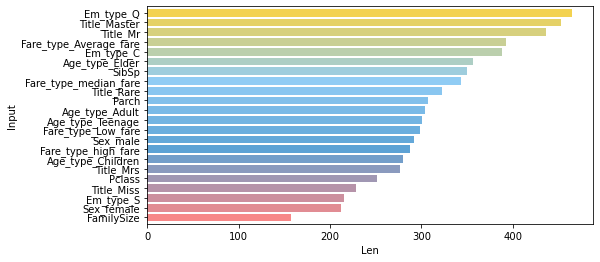

In [46]:
plot_barrage("len")

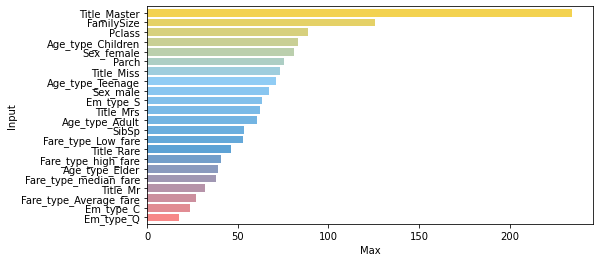

In [47]:
plot_barrage("max")

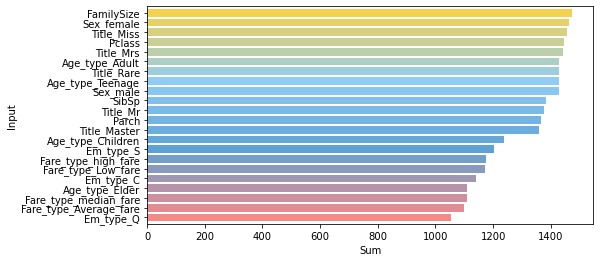

In [48]:
plot_barrage("sum")

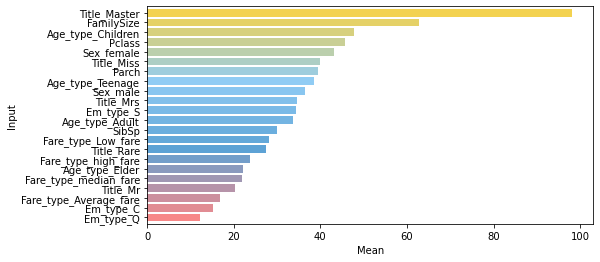

In [49]:
plot_barrage("mean")

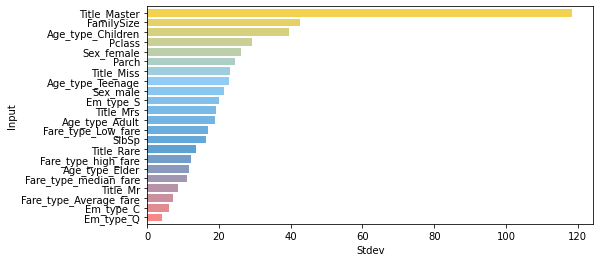

In [50]:
plot_barrage("stdev")

## Comparing Random Forest Feature Importance vs Neural Network Feature Importance

Text(0.5, 0, 'Random Forest (Left) vs Neural Network (Right)')

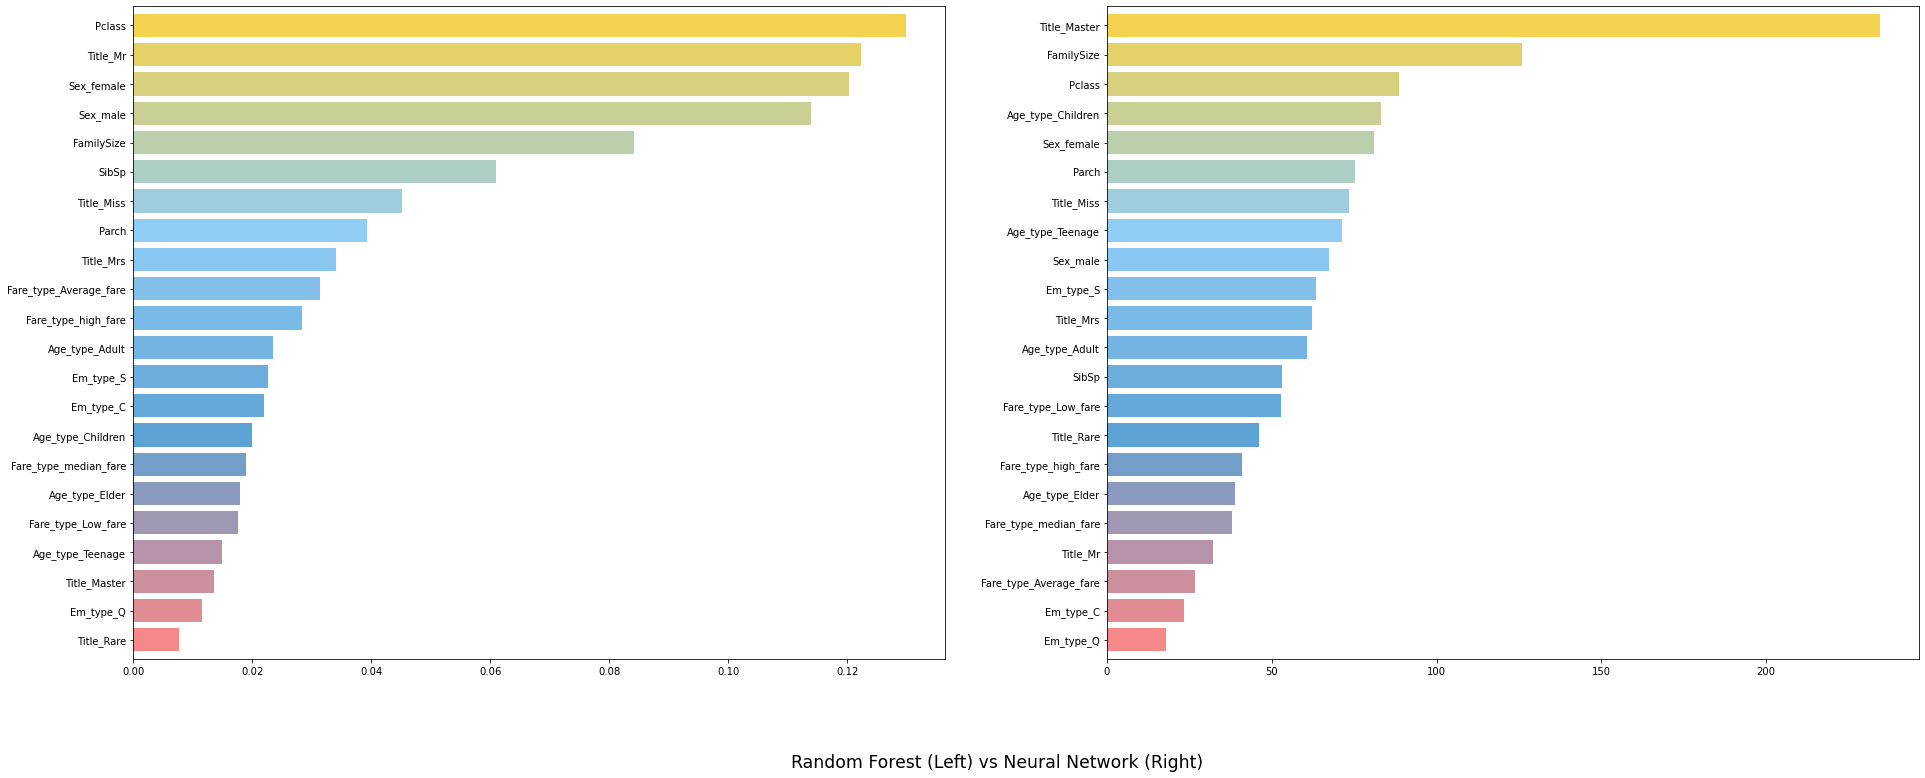

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 12))
rf = pd.Series(random_forest.feature_importances_, train_X.columns).sort_values(
    ascending=True
)
nn = pd.Series(df.loc["max"], df.columns).sort_values(ascending=True)
rf.plot.barh(width=0.8, color=colors, ax=ax1)
nn.plot.barh(width=0.8, color=colors, ax=ax2)
fig.text(
    0.5,
    0,
    s="Random Forest (Left) vs Neural Network (Right)",
    horizontalalignment="center",
    fontsize="xx-large",
)

## Comparing the Order of Feature Importance
Here we examine how closely these two sets of feature importance rankings are. To do this we use Levenshtein distance which measures the number of deletions, insertions, or substitutions required to transform one string into the other. The smaller the number, the higher the similarity. The result of this is then compared to a Montecarlo simulation that shuffles the set of values to score how it compares to chance.

In [52]:
rf_values = rf.index.values.tolist()
rf_sentence = " ".join(rf_values)

nn_values = nn.index.values.tolist()
nn_sentence = " ".join(nn_values)
score = Levenshtein.distance(rf_sentence, nn_sentence)
score

153

In [53]:
def montecarlo_this():
    res = []
    for _ in range(100000):
        sh_values = rf.index.values.tolist()
        shuffle(sh_values)
        sh_sentence = " ".join(sh_values)
        res.append(Levenshtein.distance(rf_sentence, sh_sentence))
    return res

In [54]:
res = montecarlo_this()

''

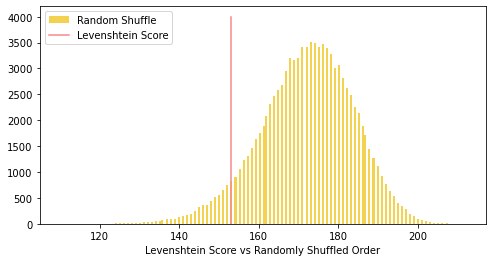

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
x = [score, score]
y = [0, 4000]
ax.hist(res, bins=200, color=important, label="Random Shuffle")
ax.plot(x, y, color=noise, label="Levenshtein Score")
ax.set_xlabel("Levenshtein Score vs Randomly Shuffled Order")
ax.legend(loc="upper left")
;

In [56]:
res_std = stdev(res)
res_mean = mean(res)
z_score = (score - res_mean) / res_std
p_value = norm.sf(abs(z_score))
print(f"This value has a probability of {round(p_value, 5)}")

This value has a probability of 0.0505
